---

## Homework


Can you make a perfect classifier? Let's consider the next dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import time
from IPython import display
from sklearn.model_selection import ParameterGrid
import pandas as pd

In [2]:
# Helpers
def add_ones(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)


def one_hot_encode(y, dim):
    return np.eye(dim)[y]


def show_scatter(x, y):
    plt.scatter(x[:,0], x[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.show()


def plot_decision_boundary(x, y, error, pred_func, inlude_bias=False):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    x_m = np.c_[xx.ravel(), yy.ravel()]
    Z = pred_func(add_ones(x_m) if inlude_bias else x_m)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    sizes = np.where(error == 0, 0, 1)*80 + 20
    plt.scatter(x[:, 0], x[:, 1], c=y, s=sizes, cmap=plt.cm.Spectral)
    plt.show()

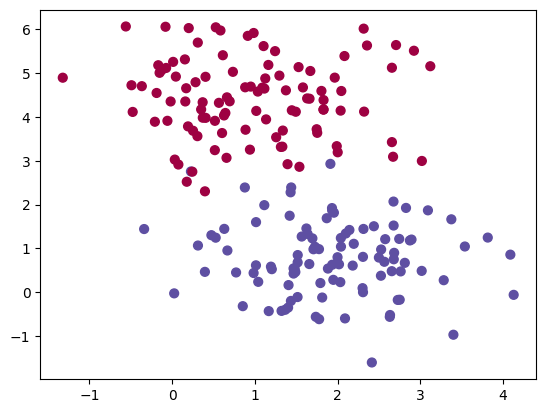

X.shape= (200, 2)


In [3]:
np.random.seed(0)
N = 200
X_test, y_test = sklearn.datasets.make_blobs(N, centers=2, cluster_std=0.9)

    
show_scatter(X_test, y_test)
print('X.shape=', X_test.shape)

#### 1. Try to tune the learning rate and number of iterations
*What is the lowest error with the current approach?*

Add early stopping to find the optimal number of iterations automatically.

Visualize the decision boundary

steps= 21 error= 0.065 w= [ 256.10059941 -161.0036358 ]


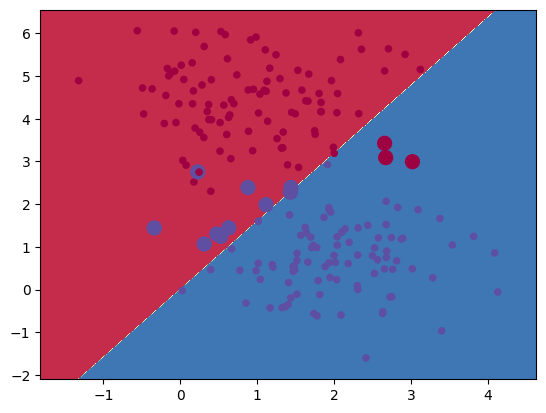

In [4]:
def activation(x):
    return np.where( x > 0 , 1, 0)

def perceptron(w, x):
    return activation(w @ x.T).T


def get_error(w, x, y):
    return y - perceptron(w, x)


def get_weigth_adjustment(lr, error, x):
    return lr * (error.T @ x)

def run_perceptron(x, y, inlude_bias, lr, max_iterations_wo_improvement = 10, max_iterations = 100):
    if inlude_bias:
        x = add_ones(x)
        
    best_w = w = np.random.random((x.shape[1], y.shape[1]) if y.ndim > 1 else x.shape[1])
    best_error_mean = prev_error_mean = np.inf    
    best_error = None
    iterations_to_best = 1
    iterations_since_best = 0

    # Limiting number of iterations to avoid infinite loop
    for j in range(max_iterations): # First has been already taken
        
        # If we're lucky and hit zero error - stop
        if prev_error_mean == 0:
            break
            
        # Give up if we're not improving for a long time
        if iterations_since_best >= max_iterations_wo_improvement:
            break
        
        error = get_error(w, x, y)        
        
        error_mean = np.mean(np.abs(error))
        iterations_since_best += 1
        
        # Store parameters of the best result
        if error_mean < best_error_mean:  
            best_error_mean = error_mean
            best_w = w
            best_error = error
            iterations_to_best = j + 1
            iterations_since_best = 0
            
        
        # Vuisualize if human is watching the progress
        if is_interactive:
            display.clear_output(wait=True)
            plot_decision_boundary(x, y, error, lambda x: perceptron(w, x), inlude_bias)
            print('j=', j+1, 'error_mean=', error_mean, 'best_error_mean=', best_error_mean, 'lr=', lr, 'w=', w)
            time.sleep(0.2)
    
        w = w + get_weigth_adjustment(lr, error, x)
        prev_error_mean = error_mean
    
    return best_w, best_error, best_error_mean, iterations_to_best + iterations_since_best


# is_interactive = True
is_interactive = False
inlude_bias = False

w, error, error_mean, steps = run_perceptron(X_test, y_test, False, 1)

display.clear_output(wait=True)
print('steps=', steps, 'error=', error_mean, 'w=', w)

plot_decision_boundary(X_test, y_test, error, lambda x: perceptron(w, x), inlude_bias)

#### 2. It's time to add learnable bias
*What is the lowest error now?*

Visualize the decision boundary

steps= 93 error= 0.015 w= [ 31.50641058 -96.06671582 202.97996233]


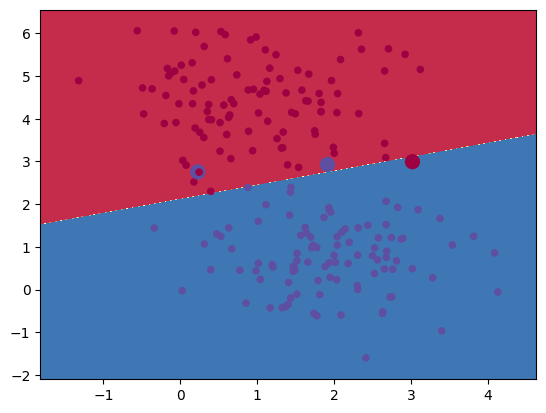

In [5]:
# is_interactive = True
is_interactive = False
inlude_bias = True

w, error, prev_error_mean, steps = run_perceptron(X_test, y_test, inlude_bias, 1, 33, 200)

display.clear_output(wait=True)
print('steps=', steps, 'error=', prev_error_mean, 'w=', w)
plot_decision_boundary(X_test, y_test, error, lambda x: perceptron(w, x), inlude_bias)

#### 3*. Let's expand it for three classes

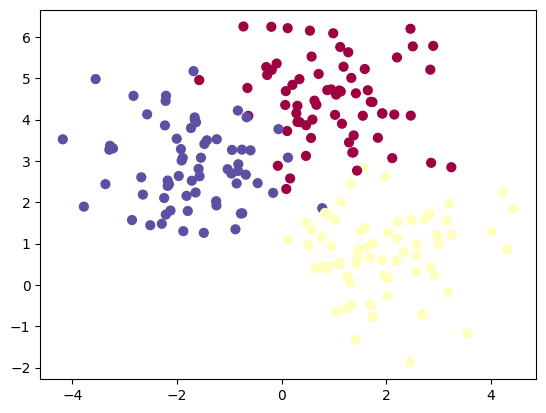

In [6]:
np.random.seed(0)
# X, y = sklearn.datasets.make_moons(200, noise=0.20)
X, y = sklearn.datasets.make_blobs(200)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

**Idea:** we need to train weights for each class 

\begin{equation}
y_p =   \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}.
\end{equation}

Visualize the decision boundary

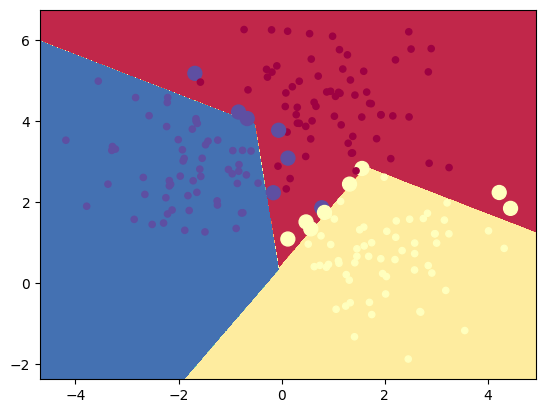

In [11]:
# One vs many approach

def predict_class(w, x):
    y = perceptron(w, x)
    return np.argmax(y, axis=1)


y_encoded = one_hot_encode(y, 3)

is_interactive = False
inlude_bias = True

w, _, _, _ = run_perceptron(X, y_encoded, inlude_bias, 1, 40, 1000)
error = np.abs(y - predict_class(w, add_ones(X)))
plot_decision_boundary(X, y, error, lambda x: predict_class(w, x), inlude_bias)


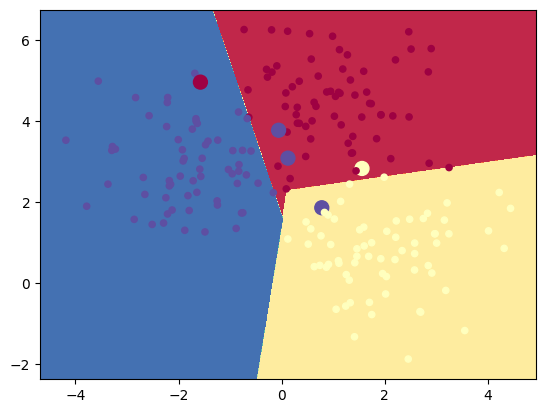

In [14]:
# One vs one approach (with loops)

def predict_class(w, x):
    y_pred = perceptron(np.array(w), x)
    df = pd.DataFrame(y_pred, columns=['t0', 't1', 't2']) # We ran 3 tests, pairing all classes
    df[['c0', 'c1', 'c2']] = 0
    for i, p in enumerate(pairs):
        t = 't' + str(i)
        df.loc[:, 'c' + str(p[0])] += np.mod(df[t] + 1, 2) # if 0 then add to class counter
        df.loc[:, 'c' + str(p[1])] += df[t] # if 1 then add to class counter
        
    rates = df[['c0', 'c1', 'c2']].to_numpy()
    
    return np.argmax(rates, axis=1)


is_interactive = False
inlude_bias = True

pairs = [[0,1],[0,2],[1,2]]
weights = []

for p in pairs:
    x_c1 = X[y==p[0]]
    x_c2 = X[y==p[1]]
    
    y_c1 = np.zeros(x_c1.shape[0])
    y_c2 = np.ones(x_c2.shape[0])
    
    X_test = np.concatenate((x_c1, x_c2))
    y_test = np.concatenate((y_c1, y_c2))
    
    w, _, _, _ = run_perceptron(X_test, y_test, inlude_bias, 1, 40, 1000)
    weights.append(w)
    
weights = np.reshape(weights, (3,3))
error = np.abs(y - predict_class(weights, add_ones(X)))
plot_decision_boundary(X, y, error, lambda x: predict_class(weights, x), inlude_bias)